Daily weather summaries obtained from: https://www.ncdc.noaa.gov/cdo-web/search

In [1]:
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_validate

In [2]:
def load_rides():
    # read cleaned data from prior notebook
    r_df = pd.read_pickle('data/rides_with_dist.pkl')

    # Aggregate rides table to daily counts
    r_df = (r_df[['start_time']].groupby(r_df['start_time'].dt.date)
                                .count()
                                .rename(columns={'start_time':'n_rides'}))

    r_df.index.names = ['date']
    r_df.index = pd.to_datetime(r_df.index)

    # Ensure we fill 0's for days that had no rides
    all_dates = pd.date_range(r_df.index.min(), r_df.index.max(), name='date')
    all_dates = pd.DataFrame({'n_rides':0}, index=all_dates)

    r_df = r_df.append(all_dates.loc[~all_dates.index.isin(r_df.index)])
    r_df = r_df.sort_values('date')
    
    return r_df

def load_weather():
    # Aggregate weather to daily averages
    weather_csvs = [
        'weather_2013.csv',
        'weather_2014.csv',
        'weather_2015_2016.csv',
        'weather_2017_2018.csv',
    ]

    weather_dfs = []
    for csv in weather_csvs:
        weather_dfs.append(pd.read_csv(f'data/{csv}'))

    w_daily = pd.concat(weather_dfs, sort=True)

    # Collapse across weather stations by taking the mean
    w_daily = w_daily.groupby('DATE').mean()
    w_daily.index.names = ['date']
    w_daily.index = pd.to_datetime(w_daily.index)
    
    return w_daily

def base_feature_engineer(df):
    df['n_rides_yesterday'] = df.n_rides.shift(1)
    df = df.drop(index=df.index[0])
    
    return df

In [3]:
r_df = load_rides()
w_df = load_weather()

C:\Users\City_Year\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2850: DtypeWarning: Columns (7,9,11,13,21,29,31,33,39,41,45,55,57,61,63,65,67,69,71,73,75) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Users\City_Year\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2850: DtypeWarning: Columns (7,13,21,27,29,31,33,39,41,45,55,57,59,61) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Users\City_Year\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2850: DtypeWarning: Columns (7,9,11,13,21,27,29,31,33,39,41,45,51,55,57,59,61) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Users\City_Year\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2850: DtypeWarning: Columns (7,9,11,13,21,29,31,33,39,41,43,45,47,49,51,53,55,57,59) have mixed types. Specify dtyp

In [4]:
w_data_dict = {
    'PRCP':'Precipitation',
#     'SNWD':'Snow depth',
    'AWND':'Average wind speed',
    'WSF2':'Fastest 2-minute wind speed',
    'WSF5':'Fastest 5-second wind speed',
#     'WDF2':'Direction of fastest 2-minute wind',
#     'WDF5':'Direction of fastest 5-second wind',
#     'WDMV':'Total wind movement',
#     'PGTM':'Peak gust time',
    'TMIN':'Minimum temperature',
    'TMAX':'Maximum temperature',
    'TAVG':'Average Temperature',
#     'DAPR':'Number of days included in the multiday precipitation total (MDPR)',
    'SNOW':'Snowfall',
#     'TOBS':'Temperature at the time of observation',
#     'WESD':'Water equivalent of snow on the ground',
#     'WESF':'Water equivalent of snowfall',
#     'MDPR':'Multiday precipitation total (use with DAPR and DWPR, if available)',
#     'WT01':'Fog, ice fog, or freezing fog (may include heavy fog)',
#     'WT02':'Heavy fog or heaving freezing fog (not always distinguished from fog)',
#     'WT03':'Thunder',
#     'WT04':'Ice pellets, sleet, snow pellets, or small hail',
#     'WT05':'Hail (may include small hail)',
#     'WT06':'Glaze or rime',
#     'WT08':'Smoke or haze',
#     'WT09':'Blowing or drifting snow',
#     'WT10':'Tornado, waterspout, or funnel cloud',
#     'WT11':'High or damaging winds',
}

In [5]:
df = r_df.merge(w_df[w_data_dict.keys()], left_index=True, 
                right_index=True, how='left')

df = base_feature_engineer(df)

df.isna().sum()

n_rides              0
PRCP                 0
AWND                 0
WSF2                 0
WSF5                 0
TMIN                 0
TMAX                 0
TAVG                 0
SNOW                 0
n_rides_yesterday    0
dtype: int64

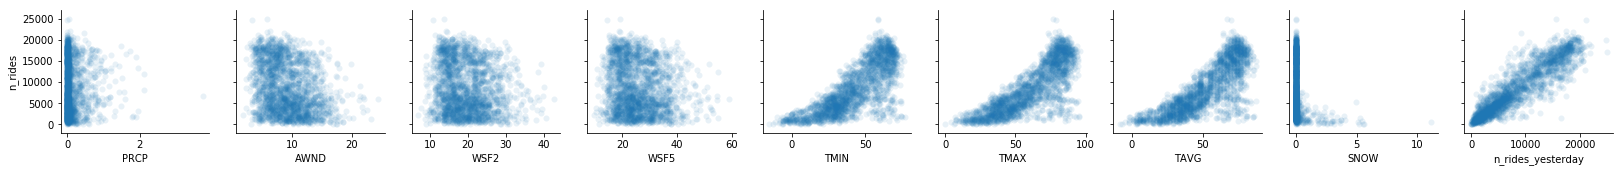

In [6]:
sns.pairplot(data=df, y_vars='n_rides', x_vars=df.columns.drop('n_rides'),
             plot_kws={'alpha': 0.1, 'linewidth':0});

In [7]:
def train_test(df):
    # separate the final 100 days into test set
    train = df[:-100]
    test  = df[-100:]
    
    X_train = train.drop(columns='n_rides')
    y_train = train['n_rides']

    X_test = test.drop(columns='n_rides')
    y_test = test['n_rides']
    
    return X_train, y_train, X_test, y_test

In [8]:
X_train, y_train, X_test, y_test = train_test(df)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1913, 9), (1913,), (100, 9), (100,))

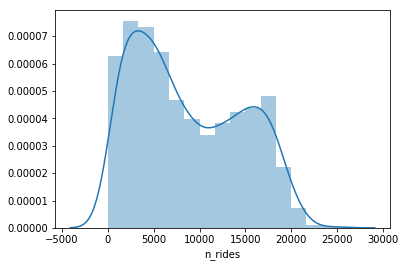

In [9]:
sns.distplot(y_train);

### Naive Models - Performance to Beat

In [10]:
y_pred = [y_train.mean()] * len(y_train)
mea = mean_absolute_error(y_train, y_pred)
print('daily average model MEA: ', mea)

y_pred = X_train['n_rides_yesterday']
mea = mean_absolute_error(y_train, y_pred)
print('same as yest. model MEA: ', mea)

daily average model MEA:  5131.410319084024
same as yest. model MEA:  1777.6941975953998


### First Viable Model

In [11]:
scores = cross_validate(LinearRegression(), X_train, y_train, 
                        scoring='neg_mean_absolute_error', 
                        n_jobs=-1, cv=3, return_estimator=True, 
                        return_train_score=True)

In [12]:
pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,0.031248,0.0,"LinearRegression(copy_X=True, fit_intercept=Tr...",-2308.323398,-1749.375524
1,0.031248,0.0,"LinearRegression(copy_X=True, fit_intercept=Tr...",-1884.992649,-1559.306095
2,0.031248,0.0,"LinearRegression(copy_X=True, fit_intercept=Tr...",-1911.829909,-1564.266567


In [13]:
scores['test_score'].mean()

-2035.0486521451855

In [14]:
for i, est in enumerate(scores['estimator']):
    print(f'Model #{i+1}',
          f"test score: {scores['test_score'][i]}",
          pd.Series(index=X_train.columns, 
                    data=est.coef_).to_string(),
          sep='\n')
    print()

Model #1
test score: -2308.3233978646044
PRCP                 -38.594264
AWND                  71.908540
WSF2                -350.604887
WSF5                 117.323473
TMIN                -125.283613
TMAX                  78.673993
TAVG                 183.513856
SNOW                  30.758600
n_rides_yesterday      0.443525

Model #2
test score: -1884.9926493126395
PRCP                 940.991716
AWND                  53.435132
WSF2                -142.316268
WSF5                   9.070702
TMIN                -109.390888
TMAX                  61.589813
TAVG                  79.659191
SNOW                -137.966466
n_rides_yesterday      0.802514

Model #3
test score: -1911.8299092583122
PRCP                 1560.289806
AWND                   84.711039
WSF2                 -155.176430
WSF5                    0.252199
TMIN                 -104.182603
TMAX                   71.046569
TAVG                   66.988408
SNOW                 -146.081060
n_rides_yesterday       0.782559



### More feature engineering

In [15]:
def feature_engineer(df):    
    # dummify day of week
    df = df.join(pd.get_dummies(df.index.day_name())
                   .set_index(df.index))
    
    # boolean holiday
    cal = USFederalHolidayCalendar()
    hdays = cal.holidays(str(df.index.min().year), 
                         str(df.index.max().year + 1))
    df = df.join(pd.Series(1, index=hdays, name='holiday'))
    df['holiday'] = df['holiday'].fillna(0)
    
    # days program has operated
    df['operating_days'] = (df.index - df.index[0]).days
    
    def hours_of_daylight(date, axis=23.44, latitude=41.876):
        """Compute the hours of daylight for the given date"""
        days = (date - pd.datetime(2000, 12, 21)).days
        m = (1. - np.tan(np.radians(latitude))
             * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
        return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

    df['daylight_hrs'] = hours_of_daylight(df.index)
    
    return df

In [16]:
df = r_df.merge(w_df[w_data_dict.keys()], left_index=True, 
                right_index=True, how='left')
df = base_feature_engineer(df)
df = feature_engineer(df)
X_train, y_train, X_test, y_test = train_test(df)

In [17]:
scores = cross_validate(LinearRegression(), X_train, y_train, 
                        scoring='neg_mean_absolute_error', 
                        n_jobs=-1, cv=3, return_estimator=True, 
                        return_train_score=True)

In [18]:
pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,0.015594,0.000000,"LinearRegression(copy_X=True, fit_intercept=Tr...",-2014.029444,-1653.961189
1,0.008995,0.003006,"LinearRegression(copy_X=True, fit_intercept=Tr...",-1809.064398,-1453.239528
2,0.007000,0.002997,"LinearRegression(copy_X=True, fit_intercept=Tr...",-2030.561355,-1485.626102


In [19]:
scores['test_score'].mean()

-1951.218398673802

In [20]:
for i, est in enumerate(scores['estimator']):
    print(f'Model #{i+1}',
          f"test score: {scores['test_score'][i]}",
          pd.Series(index=X_train.columns, 
                    data=est.coef_).to_string(),
          sep='\n')
    print()

Model #1
test score: -2014.0294435383141
PRCP                 -126.269184
AWND                   64.571814
WSF2                 -394.318364
WSF5                  151.793549
TMIN                 -118.730612
TMAX                   77.585350
TAVG                  166.843803
SNOW                   22.922428
n_rides_yesterday       0.426654
Friday                276.913190
Monday                640.078677
Saturday             -269.894972
Sunday              -1025.939339
Thursday              150.616592
Tuesday               232.082701
Wednesday              -3.856850
holiday             -1086.367070
operating_days          0.614063
daylight_hrs          181.574683

Model #2
test score: -1809.0643979176932
PRCP                  567.817369
AWND                   35.551643
WSF2                 -173.153843
WSF5                   33.621322
TMIN                 -114.229302
TMAX                   79.699888
TAVG                   76.856133
SNOW                  -66.995405
n_rides_yesterday       0.